In [1]:
!pip install trl

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 348.0/348.0 kB 13.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.5/491.5 kB 32.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 20.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 125.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 104.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 61.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 11.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 43.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 20.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [2]:
pip install trl --upgrade

In [3]:
!pip install -U trl

In [15]:
!pip install peft

In [45]:
import pandas as pd
from datasets import Dataset
from transformers import AutoTokenizer, AutoModelForCausalLM
from trl import DPOTrainer, DPOConfig
from transformers import pipeline
import torch
from torch import nn
from peft import LoraConfig, get_peft_model, TaskType
from tqdm.auto import tqdm
import evaluate
import numpy as np
import bert_score
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
import itertools
from sklearn.model_selection import train_test_split
from datetime import datetime

# Preparing dataset

In [2]:
df = pd.read_excel("simpo_preference_dataset.xlsx")
print(df.head())

df = df.rename(columns={'Prompt': 'prompt', 'Chosen': 'chosen', 'Rejected': 'rejected'})
df = df.dropna(subset=["prompt", "chosen", "rejected"])
data = df[["prompt", "chosen", "rejected"]].to_dict(orient="records")

                                              Prompt  \
0  Что такое гражданское законодательство Российс...   
1  Что такое гражданские права физических и юриди...   
2  Что такое свобода перемещения товаров, услуг и...   
3  Что такое гражданское законодательство Российс...   
4  Что такое неотчуждаемые права и свободы челове...   

                                              Chosen  \
0  Гражданское законодательство Российской Федера...   
1  Гражданские права физических и юридических лиц...   
2  Основные начала гражданского законодательства,...   
3  Свобода перемещения товаров, услуг и финансовы...   
4  Предметом гражданского законодательства являют...   

                                            Rejected  
0  Это типа такие законы, которые как бы регулиру...  
1  Гражданские права — это как бы права людей и ф...  
2  Свобода перемещения — это когда можно, типа, г...  
3  Это короче законы про имущество и прочие гражд...  
4  Неотчуждаемые права — это как бы базовые права..

In [3]:
dataset = Dataset.from_list(data)
dataset = dataset.train_test_split(test_size=0.05, seed=42)
train_dataset = dataset["train"]
eval_dataset = dataset["test"]

# Model

In [4]:
model_name = "IlyaGusev/saiga_llama3_8b"

tokenizer = AutoTokenizer.from_pretrained(model_name, use_fast=True)
model = AutoModelForCausalLM.from_pretrained(model_name, torch_dtype="auto",device_map="auto")
max_length = 512

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

In [5]:
lora_config = LoraConfig(
    r=8,
    lora_alpha=16,
    lora_dropout=0.05,
    bias="none",
    task_type=TaskType.CAUSAL_LM,
    target_modules=["q_proj", "v_proj"]
)

model = get_peft_model(model, lora_config)
print(model.print_trainable_parameters())

trainable params: 3,407,872 || all params: 8,033,669,120 || trainable%: 0.0424
None


In [6]:
def preprocess(example):
    prompt = example["prompt"]
    chosen = example["chosen"]
    rejected = example["rejected"]

    chosen_full = prompt + "\n" + chosen
    rejected_full = prompt + "\n" + rejected

    chosen_enc = tokenizer(
        chosen_full, max_length=max_length, truncation=True, padding="max_length", return_tensors="pt"
    )
    rejected_enc = tokenizer(
        rejected_full, max_length=max_length, truncation=True, padding="max_length", return_tensors="pt"
    )

    return {
        "input_ids_chosen": chosen_enc["input_ids"][0],
        "attention_mask_chosen": chosen_enc["attention_mask"][0],
        "input_ids_rejected": rejected_enc["input_ids"][0],
        "attention_mask_rejected": rejected_enc["attention_mask"][0],
    }

In [7]:
train_dataset = train_dataset.map(preprocess, remove_columns=train_dataset.column_names)
eval_dataset = eval_dataset.map(preprocess, remove_columns=eval_dataset.column_names)

Map:   0%|          | 0/1523 [00:00<?, ? examples/s]

Map:   0%|          | 0/81 [00:00<?, ? examples/s]

In [8]:
def custom_data_collator(features):
    import torch
    return {
        "input_ids_chosen": torch.stack([torch.tensor(f["input_ids_chosen"]) for f in features]),
        "attention_mask_chosen": torch.stack([torch.tensor(f["attention_mask_chosen"]) for f in features]),
        "input_ids_rejected": torch.stack([torch.tensor(f["input_ids_rejected"]) for f in features]),
        "attention_mask_rejected": torch.stack([torch.tensor(f["attention_mask_rejected"]) for f in features]),
    }

In [9]:
class DPOTrainerCustom:
    def __init__(self, model, ref_model, tokenizer, train_dataset, eval_dataset, data_collator, lr=5e-7, beta=0.1, device='cuda'):
        self.model = model
        self.ref_model = ref_model if ref_model is not None else None
        self.tokenizer = tokenizer
        self.train_dataset = train_dataset
        self.eval_dataset = eval_dataset
        self.data_collator = data_collator
        self.lr = lr
        self.beta = beta
        self.device = device

        self.optimizer = torch.optim.AdamW(self.model.parameters(), lr=lr)
        self.loss_fn = nn.CrossEntropyLoss()

    def dpo_loss(self, chosen_logp, rejected_logp, beta):
        return -torch.mean(torch.log(torch.sigmoid(beta * (chosen_logp - rejected_logp))))

    def train(self, epochs=1, batch_size=2):
        from torch.utils.data import DataLoader

        dataloader = DataLoader(
            self.train_dataset, batch_size=batch_size, shuffle=True, collate_fn=self.data_collator
        )

        self.model.train()
        for epoch in range(epochs):
            for step, batch in enumerate(dataloader):
                input_ids_chosen = batch["input_ids_chosen"].to(self.device)
                attention_mask_chosen = batch["attention_mask_chosen"].to(self.device)
                input_ids_rejected = batch["input_ids_rejected"].to(self.device)
                attention_mask_rejected = batch["attention_mask_rejected"].to(self.device)

                chosen_outputs = self.model(
                    input_ids=input_ids_chosen,
                    attention_mask=attention_mask_chosen,
                    labels=input_ids_chosen
                )
                rejected_outputs = self.model(
                    input_ids=input_ids_rejected,
                    attention_mask=attention_mask_rejected,
                    labels=input_ids_rejected
                )

                chosen_logp = -chosen_outputs.loss
                rejected_logp = -rejected_outputs.loss

                loss = self.dpo_loss(chosen_logp, rejected_logp, self.beta)

                self.optimizer.zero_grad()
                loss.backward()
                self.optimizer.step()

                if step % 10 == 0:
                    print(f"Epoch {epoch}, Step {step}, Loss: {loss.item()}")

    def generate(self, prompt, max_new_tokens=300):
        input_ids = self.tokenizer(prompt, return_tensors="pt").input_ids.to(self.device)
        output = self.model.generate(input_ids, max_new_tokens=max_new_tokens)
        return self.tokenizer.decode(output[0], skip_special_tokens=True)

# Training

In [10]:
trainer = DPOTrainerCustom(
    model=model,
    ref_model=None,
    tokenizer=tokenizer,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    data_collator=custom_data_collator,
    lr=5e-7,
    beta=0.1,
    device="cuda"
)

In [11]:
trainer.train(epochs=2, batch_size=1)

Epoch 0, Step 0, Loss: 0.5944221615791321
Epoch 0, Step 10, Loss: 0.56721031665802
Epoch 0, Step 20, Loss: 0.5685844421386719
Epoch 0, Step 30, Loss: 0.536453366279602
Epoch 0, Step 40, Loss: 0.56056809425354
Epoch 0, Step 50, Loss: 0.5844346284866333
Epoch 0, Step 60, Loss: 0.5947858691215515
Epoch 0, Step 70, Loss: 0.5922415852546692
Epoch 0, Step 80, Loss: 0.5630006194114685
Epoch 0, Step 90, Loss: 0.5835199952125549
Epoch 0, Step 100, Loss: 0.60323566198349
Epoch 0, Step 110, Loss: 0.5602007508277893
Epoch 0, Step 120, Loss: 0.614298403263092
Epoch 0, Step 130, Loss: 0.5819648504257202
Epoch 0, Step 140, Loss: 0.49340134859085083
Epoch 0, Step 150, Loss: 0.5642564296722412
Epoch 0, Step 160, Loss: 0.5775354504585266
Epoch 0, Step 170, Loss: 0.6005885601043701
Epoch 0, Step 180, Loss: 0.5635372400283813
Epoch 0, Step 190, Loss: 0.5933868288993835
Epoch 0, Step 200, Loss: 0.5546826124191284
Epoch 0, Step 210, Loss: 0.6015647649765015
Epoch 0, Step 220, Loss: 0.5795708298683167
Epoch 

In [15]:
model.save_pretrained("./saiga_llama3_8b_dpo")
tokenizer.save_pretrained("./saiga_llama3_8b_dpo")

('./saiga_llama3_8b_dpo/tokenizer_config.json',
 './saiga_llama3_8b_dpo/special_tokens_map.json',
 './saiga_llama3_8b_dpo/tokenizer.json')

In [17]:
input_text = "Что такое гражданское законодательство Российской Федерации и на каких принципах оно основывается?"
input_ids = tokenizer(input_text, return_tensors="pt").input_ids.to(model.device)
with torch.no_grad():
    out = model.generate(input_ids, max_new_tokens=256)
print(tokenizer.decode(out[0], skip_special_tokens=True))

Что такое гражданское законодательство Российской Федерации и на каких принципах оно основывается?](https://www.garant.ru/products/ipo/prime/practice/civil_law_russia)
- [Гражданский кодекс РФ: основные положения](https://www.garant.ru/products/ipo/prime/practice/gkrf)
- [Принципы гражданского права в России](https://www.garant.ru/products/ipo/prime/practice/principles_civil_right)

---

### 2.3. Общая теория государства и права

- [Общая теория государства и права: понятие, предмет, методология](https://www.garant.ru/products/ipo/prime/practice/theory_state_and_right)
- [Основные направления развития общей теории государства и права](https://www.garant.ru/products/ipo/prime/practice/development_theory_state_and_right)
- [Методологические проблемы общей теории государства и права](https://www.garant.ru/products/ipo/prime/practice/methodological_problems_theory_state_and_right)

---

### 2.4. Конституционное право

- [Конституционное право Российской Федерации: основные положения](https

In [18]:
dataset = pd.read_csv("sft_dataset.csv")
prompts = dataset["prompt"].iloc[:50].tolist()
refs = dataset["response"].iloc[:50].tolist()

In [19]:
def complete_sentence(text):
    import re
    match = list(re.finditer(r"[.!?…](?!\w)", text))
    if not match:
        return text.strip()
    last = match[-1].end()
    return text[:last].strip()

def generate_answer(prompt, max_new_tokens=512):
    inputs = tokenizer(prompt, return_tensors="pt", truncation=True, max_length=512).to(model.device)
    with torch.no_grad():
        out_ids = model.generate(
            **inputs,
            max_new_tokens=max_new_tokens,
            do_sample=False,
            pad_token_id=tokenizer.pad_token_id,
            eos_token_id=tokenizer.eos_token_id,
            early_stopping=True
        )
    gen = out_ids[0, inputs["input_ids"].shape[-1]:]
    return complete_sentence(tokenizer.decode(gen, skip_special_tokens=True).strip())

In [22]:
generated = []
for prompt in tqdm(prompts):
    answer = generate_answer(prompt)
    print(f"\nPrompt: {prompt}\nFinetuned answer: {answer}\n{'-'*50}")
    generated.append(answer)

  0%|          | 0/50 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/transformers/generation/configuration_utils.py:631: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.2` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/transformers/generation/configuration_utils.py:636: UserWarning: `do_sample` is set to `False`. However, `top_p` is set to `0.9` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_p`.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/transformers/generation/configuration_utils.py:653: UserWarning: `do_sample` is set to `False`. However, `top_k` is set to `30` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_k`.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/transformers/generation/configuration_utils.py:679: UserWarni


Prompt: Что такое гражданское законодательство Российской Федерации и на каких принципах оно основывается?
Finetuned answer: Гражданское законодательство Российской Федерации - это система правовых норм, регулирующих личные и имущественные отношения между физическими лицами, юридическими лицами и государственными органами. Основой гражданского законодательства является принципы:
1. **Сovereignty** (суверенитет) - каждый человек имеет право на защиту своих прав и свобод.
2. **Legal equality** (правовая равноправность) - все люди имеют одинаковые права перед законом.
3. **Freedom of will** (свобода воли) - каждый человек имеет право самостоятельно принимать решения о своем поведении.
4. **Property rights** (права собственности) - каждому предоставляется право на владение, пользование и распоряжение своим имуществом.
5. **Contractual freedom** (свобода договора) - возможность заключать договоры по взаимному согласию сторон.
6. **State protection** (защита государства) - государство обяза

In [23]:
result_df = pd.DataFrame({
    "prompt": prompts,
    "reference": refs,
    "generated": generated
})

result_df.to_csv("dpo_generated_answers.csv", index=False)

# Evaluation

In [24]:
!pip install bert-score evaluate torch
!pip install nltk

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.1/61.1 kB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 6.2 MB/s eta 0:00:00


In [27]:
!pip install evaluate

In [36]:
!pip install rouge_score

  Preparing metadata (setup.py) ... done
  Created wheel for rouge_score: filename=rouge_score-0.1.2-py3-none-any.whl size=24934 sha256=1bf0e5d4de5fc4f6c28bdc3da60ad1ae81b27dd5469bb8956884d9c0bddbfcf2
  Stored in directory: /root/.cache/pip/wheels/1e/19/43/8a442dc83660ca25e163e1bd1f89919284ab0d0c1475475148
Successfully built rouge_score


In [25]:
df = pd.read_csv("dpo_generated_answers.csv")
refs = df["reference"].tolist()
gens = df["generated"].tolist()

## BERTScore

In [33]:
bertscore = evaluate.load("bertscore")
bertscore_results = bertscore.compute(
    predictions=gens,
    references=refs,
    lang="ru",
    model_type="xlm-roberta-base",
    device="cuda" if torch.cuda.is_available() else "cpu"
)
print(f"BERTScore F1 (avg): {np.mean(bertscore_results['f1']):.4f}")

BERTScore F1 (avg): 0.8438


## BLEU

In [34]:
bleu = evaluate.load("bleu")
bleu_results = bleu.compute(
    predictions=gens,
    references=[[r] for r in refs]
)

print(f"BLEU score: {bleu_results['bleu']:.4f}")

BLEU score: 0.0262


## ROUGE

In [37]:
rouge = evaluate.load("rouge")
rouge_results = rouge.compute(
    predictions=gens,
    references=refs
)

print(f"ROUGE-1: {rouge_results['rouge1']:.4f}")
print(f"ROUGE-2: {rouge_results['rouge2']:.4f}")
print(f"ROUGE-L: {rouge_results['rougeL']:.4f}")

ROUGE-1: 0.0058
ROUGE-2: 0.0000
ROUGE-L: 0.0058


## Perplexity

In [38]:
tokenizer = AutoTokenizer.from_pretrained("./saiga_llama3_8b_dpo")
model = AutoModelForCausalLM.from_pretrained("./saiga_llama3_8b_dpo", torch_dtype=torch.float16 if torch.cuda.is_available() else torch.float32)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
model.eval()

losses = []
for text in tqdm(gens, desc="Calculating perplexity"):
    inputs = tokenizer(text, return_tensors="pt", truncation=True, max_length=512).to(device)
    with torch.no_grad():
        outputs = model(**inputs, labels=inputs["input_ids"])
        loss = outputs.loss.item()
        losses.append(loss)

mean_loss = np.mean(losses)
perplexity = np.exp(mean_loss)
print(f"Perplexity: {perplexity:.2f}")

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating perplexity:   0%|          | 0/50 [00:00<?, ?it/s]

Perplexity: 2.07


## Semantic textual similarity (STS)

In [39]:
refs = df["reference"].astype(str).tolist()
gens = df["generated"].astype(str).tolist()

In [42]:
model = SentenceTransformer("cointegrated/LaBSE-en-ru")

modules.json:   0%|          | 0.00/461 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/1.71k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/806 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/516M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/521k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/114 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/2.36M [00:00<?, ?B/s]

In [43]:
emb_refs = model.encode(refs, batch_size=16, show_progress_bar=True, convert_to_numpy=True, normalize_embeddings=True)
emb_gens = model.encode(gens, batch_size=16, show_progress_bar=True, convert_to_numpy=True, normalize_embeddings=True)

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

In [46]:
sims = [cosine_similarity([emb_refs[i]], [emb_gens[i]])[0, 0] for i in range(len(refs))]
mean_sim = np.mean(sims)
print(f"Semantic similarity (cosine, avg): {mean_sim:.4f}")

Semantic similarity (cosine, avg): 0.7327


In [47]:
df["semantic_similarity"] = sims
df.to_csv("dpo_with_semantic_similarity.csv", index=False)

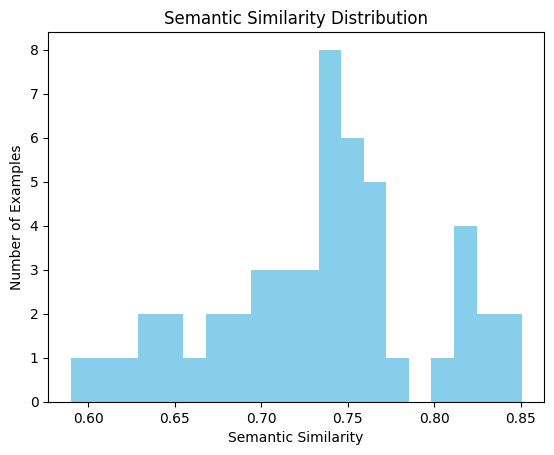

In [48]:
plt.hist(df["semantic_similarity"], bins=20, color='skyblue')
plt.xlabel("Semantic Similarity")
plt.ylabel("Number of Examples")
plt.title("Semantic Similarity Distribution")
plt.show()

In [49]:
print(df.sort_values("semantic_similarity").iloc[[0, -1]][["prompt", "reference", "generated", "semantic_similarity"]])

                                               prompt  \
2   Что такое свобода перемещения товаров, услуг и...   
10  Что такое обратная сила актов гражданского зак...   

                                            reference  \
2   Основные начала гражданского законодательства,...   
10  Под обратной силой понимается возможность расп...   

                                            generated  semantic_similarity  
2   Свобода перемещения товаров, услуг и финансовы...             0.589973  
10  Обратные силы актов гражданского законодательс...             0.850367  


In [50]:
df_semantic = pd.read_csv("dpo_with_semantic_similarity.csv")

In [51]:
min_idx = df["semantic_similarity"].idxmin()
max_idx = df["semantic_similarity"].idxmax()

print("=== Пример с МИНИМАЛЬНОЙ similarity ===")
print(f"Semantic similarity: {df.loc[min_idx, 'semantic_similarity']:.4f}\n")
print(f"PROMPT:\n{df.loc[min_idx, 'prompt']}\n")
print(f"REFERENCE:\n{df.loc[min_idx, 'reference']}\n")
print(f"GENERATED:\n{df.loc[min_idx, 'generated']}\n")

print("\n" + "="*80 + "\n")

print("=== Пример с МАКСИМАЛЬНОЙ similarity ===")
print(f"Semantic similarity: {df.loc[max_idx, 'semantic_similarity']:.4f}\n")
print(f"PROMPT:\n{df.loc[max_idx, 'prompt']}\n")
print(f"REFERENCE:\n{df.loc[max_idx, 'reference']}\n")
print(f"GENERATED:\n{df.loc[max_idx, 'generated']}\n")

=== Пример с МИНИМАЛЬНОЙ similarity ===
Semantic similarity: 0.5900

PROMPT:
Что такое свобода перемещения товаров, услуг и финансовых средств на территории Российской Федерации и на каких основаниях федеральным законом могут вводиться ограничения этого права?

REFERENCE:
Основные начала гражданского законодательства, перечисленные в Гражданском кодексе РФ, включают равенство прав участников, автономию воли, охрану и неприкосновенность собственности, обязательность исполнения договоров, добросовестность, недопустимость злоупотребления правом, ответственность за нарушение обязательств, приоритет реальных прав и публичность сделок. Именно на базе этих начал строятся все нормы, регулирующие частный оборот.

GENERATED:
Свобода перемещения товаров, услуг и финансовых средств на территории Российской Федерации является одним из основных принципов экономической политики страны. Это право позволяет гражданам, предприятиям и организациям свободно вести международные торговые операции, предостав

In [52]:
N = 3

print("=== Топ примеров с МИНИМАЛЬНОЙ similarity ===\n")
for idx, row in df.nsmallest(N, "semantic_similarity").iterrows():
    print(f"Similarity: {row['semantic_similarity']:.4f}")
    print(f"PROMPT:\n{row['prompt']}")
    print(f"REFERENCE:\n{row['reference']}")
    print(f"GENERATED:\n{row['generated']}")
    print("-"*60)

print("\n=== Топ примеров с МАКСИМАЛЬНОЙ similarity ===\n")
for idx, row in df.nlargest(N, "semantic_similarity").iterrows():
    print(f"Similarity: {row['semantic_similarity']:.4f}")
    print(f"PROMPT:\n{row['prompt']}")
    print(f"REFERENCE:\n{row['reference']}")
    print(f"GENERATED:\n{row['generated']}")
    print("-"*60)

=== Топ примеров с МИНИМАЛЬНОЙ similarity ===

Similarity: 0.5900
PROMPT:
Что такое свобода перемещения товаров, услуг и финансовых средств на территории Российской Федерации и на каких основаниях федеральным законом могут вводиться ограничения этого права?
REFERENCE:
Основные начала гражданского законодательства, перечисленные в Гражданском кодексе РФ, включают равенство прав участников, автономию воли, охрану и неприкосновенность собственности, обязательность исполнения договоров, добросовестность, недопустимость злоупотребления правом, ответственность за нарушение обязательств, приоритет реальных прав и публичность сделок. Именно на базе этих начал строятся все нормы, регулирующие частный оборот.
GENERATED:
Свобода перемещения товаров, услуг и финансовых средств на территории Российской Федерации является одним из основных принципов экономической политики страны. Это право позволяет гражданам, предприятиям и организациям свободно вести международные торговые операции, предоставлять 

In [53]:
!zip -r output_full.zip . -x "*/\.*"  # не включает скрытые папки и файлы (.ipynb_checkpoints и др.)
from google.colab import files
files.download("output_dpo.zip")

  adding: .config/ (stored 0%)
  adding: .config/config_sentinel (stored 0%)
  adding: .config/active_config (stored 0%)
  adding: .config/logs/ (stored 0%)
  adding: .config/logs/2025.05.14/ (stored 0%)
  adding: .config/logs/2025.05.14/13.38.07.566408.log (deflated 58%)
  adding: .config/logs/2025.05.14/13.37.56.530848.log (deflated 58%)
  adding: .config/logs/2025.05.14/13.38.05.736741.log (deflated 86%)
  adding: .config/logs/2025.05.14/13.38.17.706556.log (deflated 56%)
  adding: .config/logs/2025.05.14/13.37.34.542601.log (deflated 92%)
  adding: .config/logs/2025.05.14/13.38.16.976468.log (deflated 57%)
  adding: .config/hidden_gcloud_config_universe_descriptor_data_cache_configs.db (deflated 97%)
  adding: .config/gce (stored 0%)
  adding: .config/configurations/ (stored 0%)
  adding: .config/configurations/config_default (deflated 15%)
  adding: .config/default_configs.db (deflated 98%)
  adding: sft_dataset.csv (deflated 81%)
  adding: dpo_generated_answers.csv (deflated 81%)

FileNotFoundError: Cannot find file: output_dpo.zip